In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import networkx as nx

In [2]:
SCALAR_YELLOW = (0,255,255)
circle = False

In [3]:
def convolution(img, mask):
    image = img.copy()
    
    rows, cols = image.shape
    handle_matrix = np.full(image.shape, 0)
    mask_x, mask_y = mask.shape
    for row in range(1, rows-1):
        for col in range(1, cols-1):
            handle_matrix[row, col] = (image[row-mask_x//2:row-mask_x//2+mask_x,col-mask_y//2:col-mask_y//2+mask_y] * mask).sum()
    return abs(handle_matrix)

def fG(img):
    fx = np.array([[-1/2,0,1/2]])
    fy = np.array([[-1/2],[0],[1/2]])
    fx_mat = convolution(img, fx)
    fy_mat = convolution(img, fy)
    G = abs(fx_mat)+abs(fy_mat)
    minG, maxG = G.min(), G.max()
    maxDelta = maxG-minG
    G = 1-(G-minG)/maxDelta
    return G

def fD(img):
    Dn = np.array([[-1/4,0,1/4],[-1/4,0,1/4],[0, 0, 0]])
    Ds = np.array([[0, 0, 0],[-1/4,0,1/4],[-1/4,0,1/4]])
    De = np.array([[0,1/4,1/4],[0, 0, 0],[0,-1/4,-1/4]])
    Dw = np.array([[1/4,1/4,0],[0,0,0],[-1/4,-1/4,0]])
    Dne = np.array([[0,-0.707,0],[0,0,0.707],[0,0,0]])
    Dse = np.array([[0,0,0],[0,0,0.707],[0,-0.707,0]])
    Dnw = np.array([[0,0.707,0],[-0.707,0,0],[0,0,0]])
    Dsw = np.array([[0,0,0],[-0.707,0,0],[0,0.707,0]])
    
    Dn_mat = convolution(img, Dn)
    Ds_mat = convolution(img, Ds)
    De_mat = convolution(img, De)
    Dw_mat = convolution(img, Dw)
    Dne_mat = convolution(img, Dne)
    Dse_mat = convolution(img, Dse)
    Dnw_mat = convolution(img, Dnw)
    Dsw_mat = convolution(img, Dsw)
    
    Dn_mat=1-Dn_mat/Dn_mat.max()
    Ds_mat=1-Ds_mat/Ds_mat.max()
    De_mat=1-De_mat/De_mat.max()
    Dw_mat=1-Dw_mat/Dw_mat.max()
    Dne_mat=(1-Dne_mat/Dne_mat.max())*1.414
    Dse_mat=(1-Dse_mat/Dse_mat.max())*1.414
    Dnw_mat=(1-Dnw_mat/Dnw_mat.max())*1.414
    Dsw_mat=(1-Dsw_mat/Dsw_mat.max())*1.414
    result = np.minimum(np.minimum(np.minimum(Dn_mat,Ds_mat), np.minimum(De_mat, Dw_mat)),
                        np.minimum(np.minimum(Dne_mat, Dse_mat), np.minimum(Dnw_mat, Dsw_mat)))
    return result

In [4]:
def generate_edges(matrix):
    rows, cols = matrix.shape
    edges = []
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            currentPos = i*cols+j
            edge = (currentPos,currentPos-cols-1,{'weight':matrix[i-1,j-1]})
            edges.append(edge)
            edge = (currentPos,currentPos-cols,{'weight':matrix[i-1,j]})
            edges.append(edge)
            edge = (currentPos,currentPos-cols+1,{'weight':matrix[i-1,j+1]})
            edges.append(edge)
            edge = (currentPos,currentPos-1,{'weight':matrix[i,j-1]})
            edges.append(edge)
            edge = (currentPos,currentPos+1,{'weight':matrix[i,j+1]})
            edges.append(edge)
            edge = (currentPos,currentPos+cols-1,{'weight':matrix[i+1,j-1]})
            edges.append(edge)
            edge = (currentPos,currentPos+cols,{'weight':matrix[i+1,j]})
            edges.append(edge)
            edge = (currentPos,currentPos+cols+1,{'weight':matrix[i+1,j+1]})
            edges.append(edge)
            

    return edges

def shortest_path(img, DGraph,startPos, endPos):
    rows, cols = img.shape
    startIndex = startPos[0]*cols+startPos[1]
    endIndex = endPos[0]*cols+endPos[1]
    
    
    indexList = nx.dijkstra_path(DGraph, startIndex, endIndex)
    posList = [(i//cols,i%cols) for i in indexList]
    return posList


In [5]:
def mouse_actions(event, x, y, flags, param):
    img = param[0]
    img_cost = param[2]
    global circle
    if event == cv2.EVENT_LBUTTONDOWN:
        if circle == True:
            return
        xy = "%d,%d" % (x, y)
        

        for i in seleted_points:
            if get_distance((x, y), i) < 5:
                x, y = i

        
        if len(seleted_points) > 0:
            x1,y1 = seleted_points[-1]
            pathList = shortest_path(img_cost,G, (y1,x1), (y, x))
            if (x, y) not in seleted_points:
                edges_points[(x,y)] = pathList
            for index in range(1,len(pathList)):
                y1,x1 = pathList[index-1]
                y2,x2 = pathList[index]
                cv2.line(img, (x1,y1), (x2,y2),SCALAR_YELLOW,1,4)
            
            
            if (x, y) == seleted_points[0] and circle == False:
                seleted_points.append((x, y))
                edges_points[(x,y)] = pathList
                circle = True
        if circle == False:

            cv2.circle(img, (x, y), 1, (0, 0, 255), thickness=-1)
        if (x,y) not in seleted_points:
            seleted_points.append((x, y))

        cv2.imshow("image",img)

    if event == cv2.EVENT_RBUTTONDOWN:
        if len(seleted_points) > 0:
            if seleted_points[-1] in edges_points.keys():
                del edges_points[seleted_points[-1]]
            del seleted_points[-1]
            

            if circle == True:
                circle = False
            param[0] = param[1].copy()
            img = param[0]
            if len(seleted_points) >= 2:
                for index, i in enumerate(seleted_points[:-1]):
                    x1,y1 = seleted_points[index]
                    x2,y2 = seleted_points[index+1]
                    pathList = shortest_path(img_cost,G, (y1,x1), (y2, x2))
                    for j in range(1,len(pathList)):
                        y1,x1 = pathList[j-1]
                        y2,x2 = pathList[j]
                        cv2.line(img, (x1,y1), (x2,y2),SCALAR_YELLOW,1,4)
                    
                    
                    cv2.circle(img, i, 1, (0, 0, 255), thickness=-1)
                  
            if len(seleted_points) > 0:
                last_point = seleted_points[-1]

                cv2.circle(img, last_point, 1, (0, 0, 255), thickness=-1)
                
            cv2.imshow("image", img)
def get_distance(point1, point2):
    p1 = np.array(point1)
    p2 = np.array(point2)
    return (((p1-p2)**2).sum())**0.5  

In [6]:
def cost_matrix(img, wd, wg):
    img_fd = fD(img)
    img_fg = fG(img)
    l = wd*img_fd + wg*img_fg
    return np.floor(l*10)

In [7]:
def generate_object(img, pointsDist):
    binary_img = np.full(img.shape, 0)
    for key, value in pointsDist.items():
        for i in value:
            binary_img[i[0],i[1]] = 1
    return binary_img



In [8]:
def fillHole(im_in):
    im_floodfill = im_in.copy()
    im_floodfill = np.uint8(im_floodfill)
    
    h, w = im_in.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_in | im_floodfill_inv

    return im_out


In [9]:

def intellegent_scissor(img_path, wd=0.7, wg=0.3):
    img_orin = cv2.imread(img_path)
    img_gray = cv2.imread(img_path, -1)
    global circle
    img = img_orin.copy()
    img_cost = cost_matrix(img_gray, wd, wg)
    G.add_edges_from(generate_edges(img_cost))
    width = 1200
    height = 800
    cv2.namedWindow("image", 0)
    cv2.resizeWindow("image", width, height)
    cv2.setMouseCallback("image", mouse_actions, [img, img_orin, img_cost])
    cv2.imshow("image", img)
    k = cv2.waitKey(0)
    if k==13 and circle == True:
        cv2.destroyAllWindows() 
        object_edges = fillHole(generate_object(img_gray, edges_points))
        
        circle = False
        plt.imshow(object_edges,cmap='gray')
        plt.show()

    if k==27:
        
        circle = False
        cv2.destroyAllWindows() 

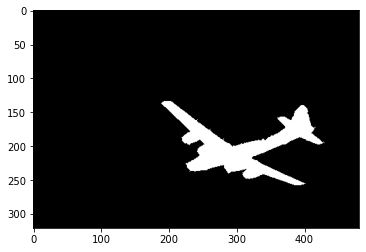

In [10]:
# left-click to select seed and free points
# right-click to recall the last point
# press ESC to quit the tool
# press Enter to confirm the circle of object and generate binary output after selecting back to the seed
# to make the circle
seleted_points=[]
edges_points={}
G = nx.DiGraph()
intellegent_scissor('./Intelligent Scissors/plane.pgm')